# Mitigating Bias in Machine Learning Models for Student Depression Prediction

### Team Details

- Teammate 1: Lance Santana
- Teammate 2: Megan Yip
- Teammate 3: Cole Hammes
- Teammate 4: Arnav Swami

---

# Installs

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install ucimlrepo
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.9 MB/s eta 0:00:00


# Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

# Loading dataset
_(same as previous milestone, copy-paste)_

In [ ]:
# Load your selected dataset
df = pd.read_csv("Student Depression Dataset.csv")

In [ ]:
# ONLY RUN CELL ONCE
# Define bins for Degree categorization
degree_mapping = {
    'Class 12': 'High School',
    'BSc': 'Undergraduate', 'BA': 'Undergraduate', 'BCA': 'Undergraduate', 'B.Pharm': 'Undergraduate',
    'BE': 'Undergraduate', 'B.Ed': 'Undergraduate', 'BHM': 'Undergraduate', 'LLB': 'Undergraduate','MBBS': 'Undergraduate',
    'B.Com': 'Undergraduate', 'B.Arch': 'Undergraduate', 'B.Tech': 'Undergraduate', 'BBA': 'Undergraduate',
    'M.Tech': 'Masters', 'MSc': 'Masters', 'M.Ed': 'Masters', 'M.Pharm': 'Masters',
    'MCA': 'Masters', 'MA': 'Masters', 'MBA': 'Masters', 'M.Com': 'Masters',
    'ME': 'Masters', 'MHM': 'Masters', 'LLM': 'Masters',
    'PhD': 'Doctorate', 'MD': 'Doctorate',
    'Others': 'Other'
}
df['Degree Category'] = df['Degree'].map(degree_mapping).fillna('Other')
df.drop(columns=['Degree'], inplace=True)

In [ ]:
education_mapping = {
    'High School' : 'Pre-Graduate', 'Undergraduate' : 'Pre-Graduate',
    'Masters' : 'Post-Graduate', 'Doctorate' : 'Post-Graduate',
    'Other' : 'Other'
}

df['Education Status'] = df['Degree Category'].map(education_mapping).fillna('Other')

In [ ]:
# Encode Education Status as a binary variable (Pregrad = 0, Postgrad = 1)
education_binary_mapping = {
    'Pre-Graduate': 0,
    'Post-Graduate': 1
}

df['Education Status'] = df['Education Status'].map(education_binary_mapping).fillna(0)  # Assign 'Other' as 0

In [ ]:
X = df.drop(columns= ["Depression"]) # features
y = df["Depression"] # target
sensitive_feature_colname = "Education Status" # sensitive feature name

# Make sensitive features-based group labels (this is g_lable)
group_labels = df[sensitive_feature_colname].values

# Print some stats
print(f"No. of samples: {X.shape[0]}")
print(f"No. of features: {X.shape[1]}")
print(f"Group Counts: {dict(collections.Counter(group_labels))}")
df.head()

No. of samples: 27901
No. of features: 18
Group Counts: {0.0: 27901}


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Degree Category,Education Status
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,Yes,3.0,1.0,No,1,Undergraduate,0.0
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,No,3.0,2.0,Yes,0,Undergraduate,0.0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,No,9.0,1.0,Yes,0,Undergraduate,0.0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,Yes,4.0,5.0,Yes,1,Undergraduate,0.0
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,Yes,1.0,1.0,No,0,Masters,0.0


## Exploratory Data Analysis

In [ ]:
df['Education Status'].value_counts()

,count
Education Status,
0.0,19450
1.0,8451


<ipython-input-17-ac1d80abacd0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['Gender'], palette = "coolwarm")
<ipython-input-17-ac1d80abacd0>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['Depression'], palette = "coolwarm")
<ipython-input-17-ac1d80abacd0>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['Degree Category'], palette = "pastel")
<ipython-input-17-ac1d80abacd0>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable

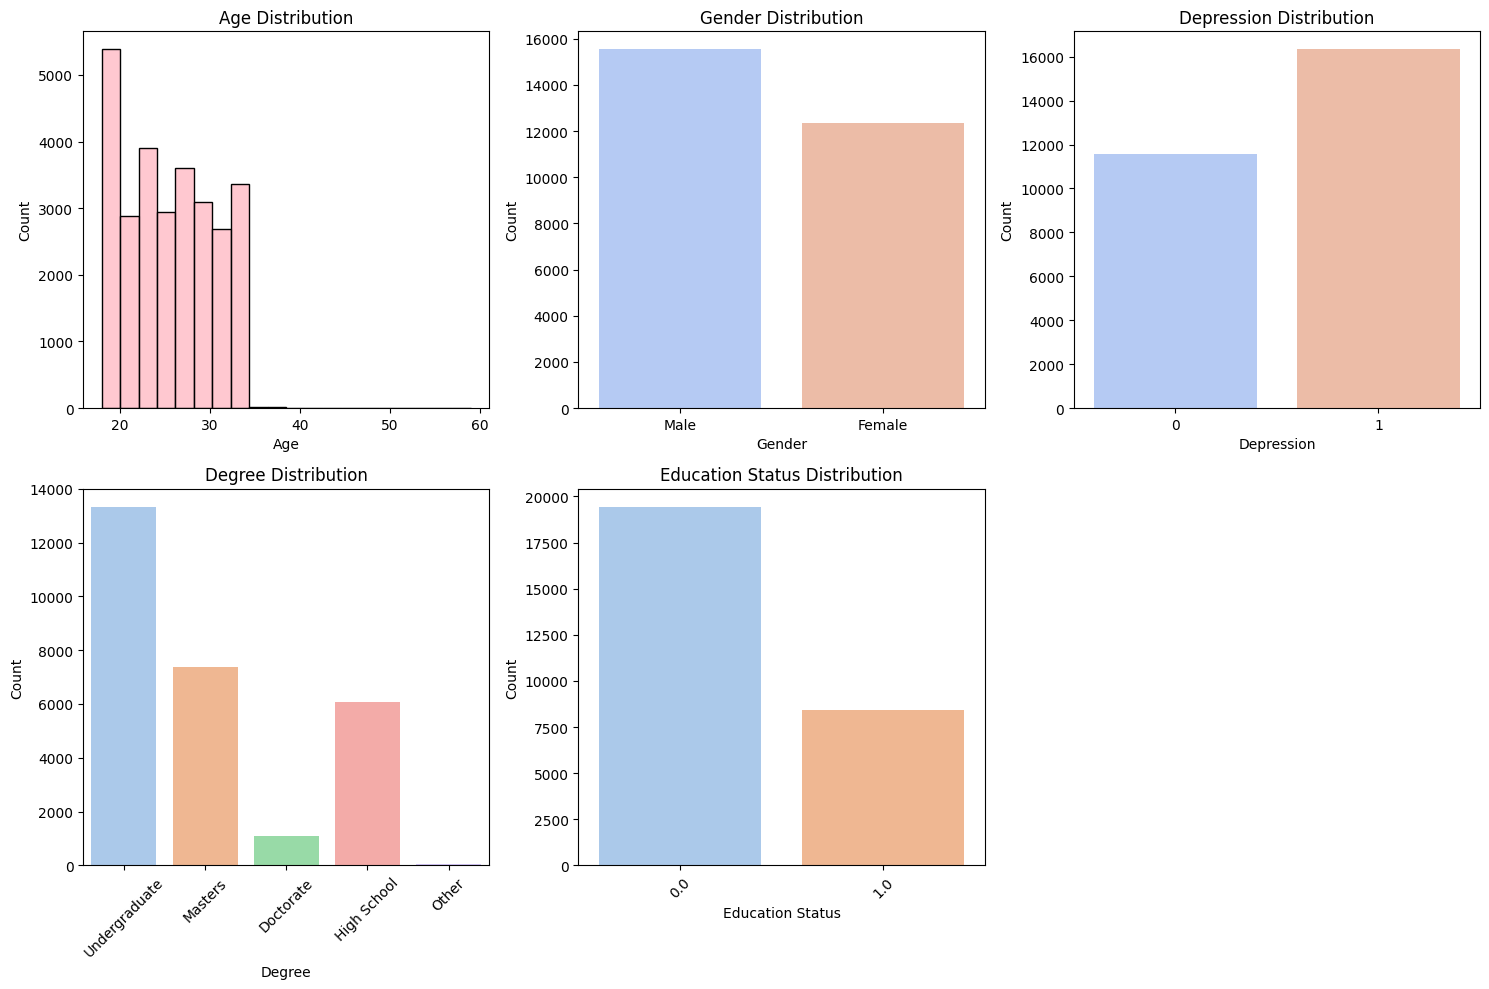

In [ ]:
# Plotting variabel distributions

# the df_compas data
plt.figure(figsize=(15, 10))

# Age distribution
plt.subplot(2, 3, 1)
sns.histplot(df['Age'], bins = 20, color = 'lightpink')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")

# Sex distribution
plt.subplot(2, 3, 2)
sns.countplot(x = df['Gender'], palette = "coolwarm")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")

# Depression distribution
plt.subplot(2, 3, 3)
sns.countplot(x = df['Depression'], palette = "coolwarm")
plt.xlabel("Depression")
plt.ylabel("Count")
plt.title("Depression Distribution")

# Degree distribution
plt.subplot(2, 3, 4)
sns.countplot(x = df['Degree Category'], palette = "pastel")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.title("Degree Distribution")

# Education Status distribution
plt.subplot(2, 3, 5)
sns.countplot(x = df['Education Status'], palette = "pastel")
plt.xlabel("Education Status")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.title("Education Status Distribution")


# Show the plots
plt.tight_layout()
plt.show()

From the above 4 graphs, we can see there are is a large number of 18-20 year olds in the data set. We can also see there are more males than females featured and overall more depressed individuals than not-depressed. We can also see there is an overwhelmingly large number of those who completed an undergraduate degree featured in this data compared to other levels of education.

<ipython-input-10-9bb8113d1140>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
<ipython-input-10-9bb8113d1140>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)


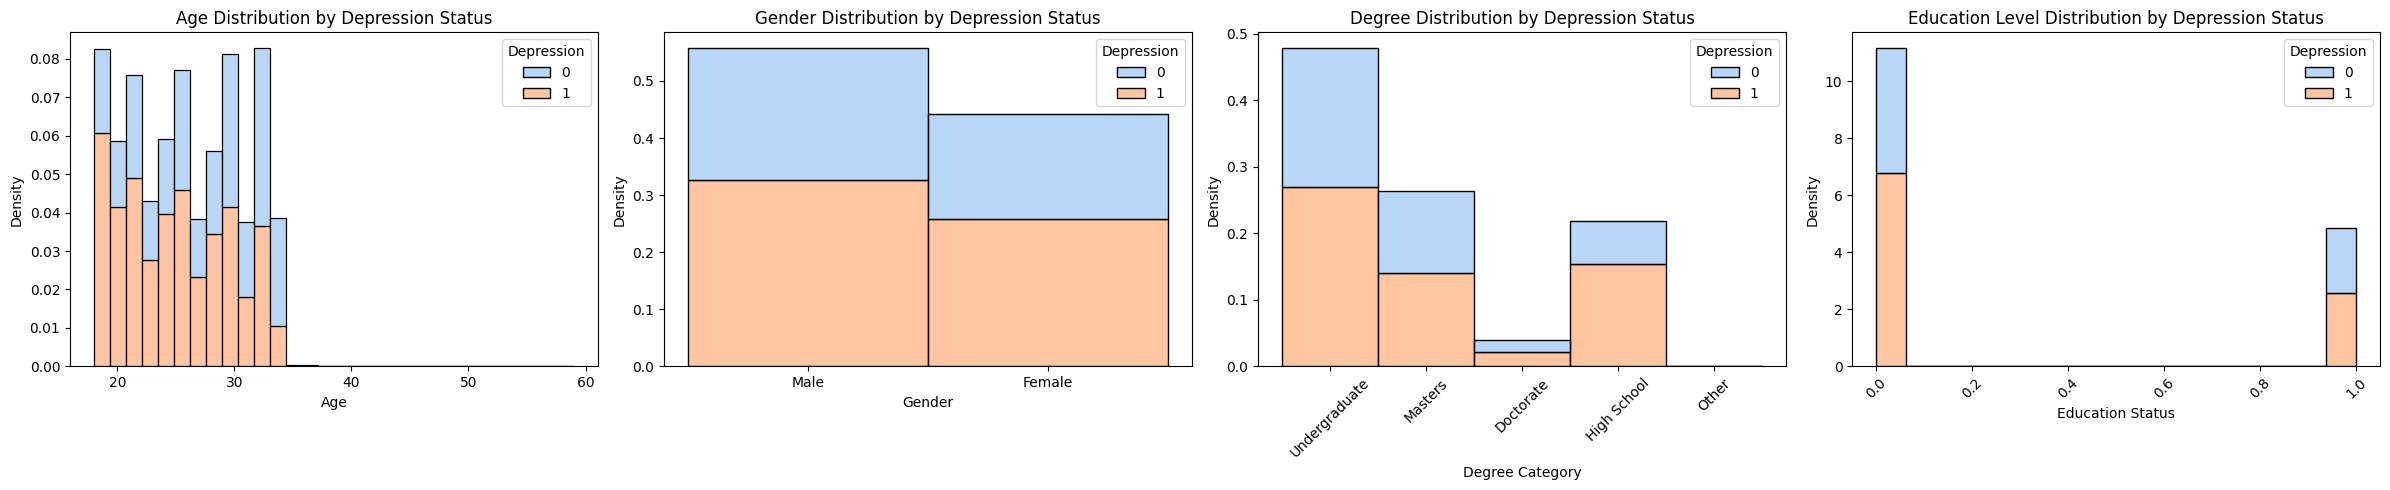

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Age Distribution by Depression Status
sns.histplot(data=df, x='Age', hue='Depression', stat="density", bins=30, multiple="stack", ax=axes[0], palette="pastel")
axes[0].set_title('Age Distribution by Depression Status')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')

# Gender Distribution by Depression Status
sns.histplot(data=df, x='Gender', hue='Depression', stat="density", multiple="stack", ax=axes[1], palette = "pastel")
axes[1].set_title('Gender Distribution by Depression Status')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Density')

# Degree Distribution by Depression Status
sns.histplot(data=df, x='Degree Category', hue='Depression', stat="density", multiple="stack", ax=axes[2], palette = "pastel")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
axes[2].set_title('Degree Distribution by Depression Status')
axes[2].set_xlabel('Degree Category')
axes[2].set_ylabel('Density')

# Education Level Distribution by Depression Status
sns.histplot(data=df, x='Education Status', hue='Depression', stat="density", multiple="stack", ax=axes[3], palette = "pastel")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)
axes[3].set_title('Education Level Distribution by Depression Status')
axes[3].set_xlabel('Education Status')
axes[3].set_ylabel('Density')

plt.tight_layout()
plt.show()

Based on the above graphs comparing the distributions of age, gender, and degree category to depression, we can expect some biases may appear in our models. From age, we see that the older individuals are categorized as not depressed, potentially leading our models to misclassify older populations since there are more younger populations in the dataset. In gender, there are a disproportionate number of females and males in the data set, as well as more classified as depressed than not. This may also introduce bias to our dataset. In the last graph of degree level, we still see that more are classified as depressed than not and we can see the disproportionality among each degree classification, potentially introducing bias.

# Preparing dataset
_(same as previous milestone, copy-paste)_

In [ ]:
# Some subset of following dataset preparation steps may be necessary depending on your dataset,
# 1. Drop unnecessary features
# 2. Handle missing data
# 3. Encode categorical features
# 4. Normalize numerical features
# 5. Encode target (if your task is classification)

# 1. Drops columns that are mostly empty
missing_values = df.isnull().mean().sort_values(ascending= False)
columns_to_drop = missing_values[missing_values > .5].index.tolist()
df.drop(columns= columns_to_drop, inplace= True)
df.drop(columns=['City'], inplace=True)
df.drop(columns=['Degree Category'], inplace=True)
df.drop(df[df['Education Status'] == 'Other'].index, inplace=True)

In [ ]:
# 2. Handle Missing date
# Fill numerical missing values with the median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# Fill categorical missing values with "Unknown"
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

In [ ]:
# 3. Encode categorical features
categorical_cols = df.select_dtypes(include = ['object', 'category']).columns.tolist()
one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
encoded_cat_data = one_hot_encoder.fit_transform(df[categorical_cols])

# Convert to DataFrame with appropriate column names
encoded_cat_columns = one_hot_encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_cat_data, columns = encoded_cat_columns, index = df.index)

# Drop original categorical columns and merge with the main dataset
df.drop(columns=categorical_cols, inplace = True)
df = pd.concat([df, df_encoded], axis = 1)

In [ ]:
# 4. Normalizing numerical values not necessary for this dataset

In [ ]:
# 5. Target variable 'Depression' listed as a binary already

X = df.drop(columns=["Depression"])  # Features
y = df["Depression"]  # Target
sensitive_feature_colname = "Education Status"  # Sensitive feature
group_labels = df[sensitive_feature_colname].values  # Group labels

# Note: X and y have been modified before the following lines of code!
print(f"No. of samples AFTER cleaning: {X.shape[0]}")
assert X.shape[0] == y.shape[0] == group_labels.shape[0] ## Ensure that the target and group_labels have been updated if some samples were removed during cleaning.
print(f"No. of features AFTER encoding: {X.shape[1]}")

No. of samples AFTER cleaning: 27901
No. of features AFTER encoding: 39


# Getting training and testing sets

Note: Train-test split is made **ONCE** to obtain the _training set_ and the _testing set_ and every teammate will use the training set to train their baseline model and test the trained model using the testing set. **NEVER** modify the testing set once it has been created.
Therefore, the following code cell does not need to be edited.

_(same as previous milestone, copy-paste)_

In [ ]:
X_train, X_test, \
  y_train, y_test, \
    group_labels_train, group_labels_test = train_test_split(X, y, group_labels, test_size=0.2, random_state=42)

print(f"No. of training samples: {X_train.shape[0]}")
print(f"No. of testing samples: {X_test.shape[0]}")

# Delete X, y and group_label variables to make sure they are not used later on.
del X
del y
del group_labels

No. of training samples: 22320
No. of testing samples: 5581


# Setting up evaluation metrics
Note: The same evaluation function will be used by all teammates.

_(same as previous milestone, copy-paste)_

In [ ]:
def evaluate_model(y_test, y_pred, g_labels):
    """
    Evaluate the performance of your trained model on the testing set.

    Parameters
    ----------
    y_test : array-like
        The true labels of the testing set.
    y_pred : array-like
        The predicted labels of the testing set.
    g_labels : array-like
        The group labels of the testing set.

    Returns
    -------
    results : dict
        A dictionary containing task-specific performance metrics and fairness metrics.
    """
    results = {}

    # Overall Performance Metrics
    results["accuracy"] = round(accuracy_score(y_test, y_pred), 4)
    results["precision"] = round(precision_score(y_test, y_pred, average="weighted", zero_division=0), 4)
    results["recall"] = round(recall_score(y_test, y_pred, average="weighted", zero_division=0), 4)
    results["f1_score"] = round(f1_score(y_test, y_pred, average="weighted", zero_division=0), 4)
    results["confusion_matrix"] = confusion_matrix(y_test, y_pred).tolist()

    # Group-based Performance Metrics
    unique_groups = np.unique(g_labels)
    group_performance = {}

    for group in unique_groups:
        group_idx = np.array(g_labels) == group  # Ensure g_labels is a NumPy array
        if np.sum(group_idx) < 5:  # Skip groups with very few samples (optional)
            continue

        group_performance[group] = {
            "accuracy": round(accuracy_score(y_test[group_idx], y_pred[group_idx]), 4),
            "precision": round(precision_score(y_test[group_idx], y_pred[group_idx], average="weighted", zero_division=0), 4),
            "recall": round(recall_score(y_test[group_idx], y_pred[group_idx], average="weighted", zero_division=0), 4),
            "f1_score": round(f1_score(y_test[group_idx], y_pred[group_idx], average="weighted", zero_division=0), 4),
            "confusion_matrix": confusion_matrix(y_test[group_idx], y_pred[group_idx]).tolist(),
        }

    results["group_performance"] = group_performance

    # Fairness Metrics
    results["demographic_parity_difference"] = round(
        demographic_parity_difference(y_test, y_pred, sensitive_features=g_labels), 4
    )
    results["equalized_odds_difference"] = round(
        equalized_odds_difference(y_test, y_pred, sensitive_features=g_labels), 4
    )

    return results


# Training baseline models (INDIVIDUAL CONTRIBUTION)
_(minor modifications from previous milestone)_

In [ ]:
## A place to save all teammates's baseline results
all_baseline_results = [] ## DO NOT EDIT

## Teammate 1: Lance - Logistic Regression

In [ ]:
# Select a model and train it on the training set
import sklearn
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Make predictions on the testing set and store them in y_pred
y_pred = clf.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)
results

# Save your results to all_baseline_results
results['teammate'] = 'Teammate 1'
results['experiment_type'] = 'baseline'
results['predictor_model'] = "Logistic Regression"
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)
pprint(results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.8,
 'confusion_matrix': [[1699, 644], [472, 2766]],
 'demographic_parity_difference': 0.1223,
 'equalized_odds_difference': 0.0972,
 'experiment_type': 'baseline',
 'f1_score': 0.7988,
 'group_performance': {0.0: {'accuracy': 0.8042,
                             'confusion_matrix': [[1076, 478], [276, 2021]],
                             'f1_score': 0.8015,
                             'precision': 0.8035,
                             'recall': 0.8042},
                       1.0: {'accuracy': 0.7908,
                             'confusion_matrix': [[623, 166], [196, 745]],
                             'f1_score': 0.791,
                             'precision': 0.7917,
                             'recall': 0.7908}},
 'mitigation_strategy': 'NONE',
 'precision': 0.7992,
 'predictor_model': 'Logistic Regression',
 'recall': 0.8,
 'teammate': 'Teammate 1'}


## Teammate 2: Megan - Random Forest Classifier

In [ ]:
# Select a model and train it on the training set
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

# Make predictions on the testing set and store them in y_pred
y_pred = rfc.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)
results

# Save your results to all_baseline_results
results['teammate'] = 'Teammate 2'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Random Forest Classifier'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint(results)

{'accuracy': 0.8273,
 'confusion_matrix': [[1811, 532], [432, 2806]],
 'demographic_parity_difference': 0.0651,
 'equalized_odds_difference': 0.0396,
 'experiment_type': 'baseline',
 'f1_score': 0.8267,
 'group_performance': {0.0: {'accuracy': 0.8328,
                             'confusion_matrix': [[1190, 364], [280, 2017]],
                             'f1_score': 0.8319,
                             'precision': 0.832,
                             'recall': 0.8328},
                       1.0: {'accuracy': 0.815,
                             'confusion_matrix': [[621, 168], [152, 789]],
                             'f1_score': 0.8149,
                             'precision': 0.8148,
                             'recall': 0.815}},
 'mitigation_strategy': 'NONE',
 'precision': 0.8267,
 'predictor_model': 'Random Forest Classifier',
 'recall': 0.8273,
 'teammate': 'Teammate 2'}


##Teammate 3: Cole Hammes - Decision Tree Classifier

In [ ]:
# Initialize and train the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Make predictions on the testing set and store them in y_pred
y_pred = clf.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)
results

# Save your results to all_baseline_results
results['teammate'] = 'Teammate 3'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Decision Tree'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint(results)

{'accuracy': 0.7576,
 'confusion_matrix': [[1678, 665], [688, 2550]],
 'demographic_parity_difference': 0.0709,
 'equalized_odds_difference': 0.054,
 'experiment_type': 'baseline',
 'f1_score': 0.7577,
 'group_performance': {0.0: {'accuracy': 0.7637,
                             'confusion_matrix': [[1096, 458], [452, 1845]],
                             'f1_score': 0.7636,
                             'precision': 0.7636,
                             'recall': 0.7637},
                       1.0: {'accuracy': 0.7439,
                             'confusion_matrix': [[582, 207], [236, 705]],
                             'f1_score': 0.7442,
                             'precision': 0.745,
                             'recall': 0.7439}},
 'mitigation_strategy': 'NONE',
 'precision': 0.7579,
 'predictor_model': 'Decision Tree',
 'recall': 0.7576,
 'teammate': 'Teammate 3'}


## Teammate 4: Arnav - Linear Discriminant Analysis

In [ ]:
# Select a model and train it on the training set
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize and train the Linear Discriminant Analysis classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)
results

# Save your results to all_baseline_results
results['teammate'] = 'Teammate 4'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Linear Discriminant Analysis'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint(results)

{'accuracy': 0.8382,
 'confusion_matrix': [[1822, 521], [382, 2856]],
 'demographic_parity_difference': 0.061,
 'equalized_odds_difference': 0.0314,
 'experiment_type': 'baseline',
 'f1_score': 0.8374,
 'group_performance': {0.0: {'accuracy': 0.8426,
                             'confusion_matrix': [[1198, 356], [250, 2047]],
                             'f1_score': 0.8416,
                             'precision': 0.842,
                             'recall': 0.8426},
                       1.0: {'accuracy': 0.8283,
                             'confusion_matrix': [[624, 165], [132, 809]],
                             'f1_score': 0.828,
                             'precision': 0.8282,
                             'recall': 0.8283}},
 'mitigation_strategy': 'NONE',
 'precision': 0.8377,
 'predictor_model': 'Linear Discriminant Analysis',
 'recall': 0.8382,
 'teammate': 'Teammate 4'}


# Mitigating Bias (INDIVIDUAL CONTRIBUTION)

_(new in this milestone)_


In [ ]:
## A place to save all teammates' post-mitigation results
all_mitigated_results = [] ## DO NOT EDIT

## Teammate 1: Lance - SMOTE w/ Scaling

In [ ]:
# Implement your bias mitigation strategy
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

#Scaling the features to improve model convergence
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Applying smote after doing scaling
smote = SMOTE(random_state = 42)
x_smote, y_smote = smote.fit_resample(X_train_scale, y_train)

#Train Logistic Regression Model on the resampled features
midigated = LogisticRegression(random_state = 0, max_iter = 500).fit(x_smote, y_smote)

# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = midigated.predict(X_test_scaled)

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 1'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Logistic Regression'
results_mitigated['mitigation_strategy'] = 'Preprocessing: SMOTE'
all_mitigated_results.append(results_mitigated)

pprint(results_mitigated)

{'accuracy': 0.8344,
 'confusion_matrix': [[1947, 396], [528, 2710]],
 'demographic_parity_difference': 0.066,
 'equalized_odds_difference': 0.0518,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.835,
 'group_performance': {0.0: {'accuracy': 0.8429,
                             'confusion_matrix': [[1289, 265], [340, 1957]],
                             'f1_score': 0.8434,
                             'precision': 0.8446,
                             'recall': 0.8429},
                       1.0: {'accuracy': 0.8156,
                             'confusion_matrix': [[658, 131], [188, 753]],
                             'f1_score': 0.8159,
                             'precision': 0.818,
                             'recall': 0.8156}},
 'mitigation_strategy': 'Preprocessing: SMOTE',
 'precision': 0.8365,
 'predictor_model': 'Logistic Regression',
 'recall': 0.8344,
 'teammate': 'Teammate 1'}


### Teammate 1's Conclusions
The results of implementing SMOTE with convergence show a moderate fairness increase across all fairness metrics. Accuracy, F1 Score, Precision, and Recall all showed an increase of about ~3.5%, showing a measurable change in fairness. Demographic parity decreased from .12 to .066, half of the original score. Equalized offs showed a similar decrease, going from .0972 to .0518. Overal, there is a higher accuracy, better balance, fewer false results, and fairer outcomes.

The results without implementing convergence showed worse outcomes with an increase in demographic parity and equalized odds of about 1%. As well as varying effects on F1, Accuracy, Precision, and recall increasing or decreasing less than 1%.

## Teammate 2: Megan - Random Forest Classifier w/ Massaging Preprocessing

In [ ]:
# defining function for massaging dataset
def apply_massaging(df, protected_col, target_col, flip_fraction=0.05):
    df_massaged = df.copy()

    # Compute group sizes
    privileged_group = df_massaged[protected_col] == 1  # Postgraduates
    unprivileged_group = df_massaged[protected_col] == 0  # Pregraduates

    privileged_size = df_massaged[privileged_group].shape[0]
    unprivileged_size = df_massaged[unprivileged_group].shape[0]

    # Compute number of samples to flip based on the smaller group
    num_flip = int(flip_fraction * min(privileged_size, unprivileged_size))  # Use minimum size to balance

    # Ensure the number of samples does not exceed available samples
    num_flip = min(num_flip, int(0.1 * min(privileged_size, unprivileged_size)))  # Prevent over-flipping

    # Identify samples to flip
    privileged_negative = df_massaged[(privileged_group) & (df_massaged[target_col] == 1)].sample(num_flip, random_state = 42)
    unprivileged_positive = df_massaged[(unprivileged_group) & (df_massaged[target_col] == 0)].sample(num_flip, random_state = 42)

    # Relabel selected samples
    df_massaged.loc[privileged_negative.index, target_col] = 0  # Demote some privileged positives
    df_massaged.loc[unprivileged_positive.index, target_col] = 1  # Promote some unprivileged negatives

    print(f"Massaging applied with balanced flipping: {num_flip} samples flipped in both groups.")
    return df_massaged

In [ ]:
# Apply massaging to training set
df_train = X_train.copy()
df_train["Depression"] = y_train
df_train_massaged = apply_massaging(df_train, protected_col="Education Status", target_col="Depression")

# Extract massaged training features and labels
X_train_m = df_train_massaged.drop(columns=["Depression"])
y_train_m = df_train_massaged["Depression"]

# Train a logistic regression model on massaged training data
rfc_mitigated = RandomForestClassifier(random_state = 42)
rfc_mitigated.fit(X_train_m, y_train_m)

# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = rfc_mitigated.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 2'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Random Forest Classifier'
results_mitigated['mitigation_strategy'] = 'Preprocessing: Massaging'
all_mitigated_results.append(results_mitigated)

pprint(results_mitigated)

Massaging applied with balanced flipping: 336 samples flipped in both groups.
{'accuracy': 0.8285,
 'confusion_matrix': [[1818, 525], [432, 2806]],
 'demographic_parity_difference': 0.111,
 'equalized_odds_difference': 0.0846,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.828,
 'group_performance': {0.0: {'accuracy': 0.8354,
                             'confusion_matrix': [[1170, 384], [250, 2047]],
                             'f1_score': 0.834,
                             'precision': 0.8347,
                             'recall': 0.8354},
                       1.0: {'accuracy': 0.8133,
                             'confusion_matrix': [[648, 141], [182, 759]],
                             'f1_score': 0.8136,
                             'precision': 0.8148,
                             'recall': 0.8133}},
 'mitigation_strategy': 'Preprocessing: Massaging',
 'precision': 0.828,
 'predictor_model': 'Random Forest Classifier',
 'recall': 0.8285,
 'teammate': 'Teammate 2'}


### Teammate 2's Conclusions
After applying balanced massaging bias mitigation, the model's overall performance improved slightly, with accuracy increasing from 82.73% to 82.85% (+0.12%) and F1-score rising from 82.67% to 82.80% (+0.13%). However, fairness metrics worsened, as Demographic Parity Difference increased from 0.0651 to 0.1110 (+70.48%), and Equalized Odds Difference rose from 0.0396 to 0.0846 (+113.64%), indicating greater disparities between education groups. While Pregraduate classification improved (+0.26%), Postgraduate accuracy declined (-0.17%), suggesting that massaging may have overcompensated. These results indicate that massaging preserved model performance but was not as effective in reducing bias.






## Teammate 3: Cole - Fairness Loss

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def fairness_loss(y_true, y_pred, group_labels, lambda_fairness=0.1):
    # Classification loss, lower is better
    acc_loss = 1 - accuracy_score(y_true, y_pred)
    # Fairness penalty(average differences between the two groups)
    fairness_pen = np.abs(np.mean(y_pred[group_labels == 0]) - np.mean(y_pred[group_labels == 1]))

    return acc_loss + lambda_fairness * fairness_pen  # Weighted sum of accuracy and fairness

def train_fair_decision_tree(X_train, y_train, group_labels_train, lambda_fairness=0.1):
    best_loss = float("inf")
    best_model = None

    #Test to find ideal length of tree nodes for fairness and accuracy balance
    for depth in range(1, 6):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)

        loss = fairness_loss(y_train, y_pred, group_labels_train, lambda_fairness)
        if loss < best_loss:  # Keep the best model
            best_loss = loss
            best_model = clf

    return best_model

# Train model with fairness loss
clf_fair = train_fair_decision_tree(X_train, y_train, group_labels_train, lambda_fairness=0.2)

# Predict and evaluate
y_pred_mitigated = clf_fair.predict(X_test)
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)


# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 3'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Decision Tree'
results_mitigated['mitigation_strategy'] = 'Inprocessing: Fairness Loss Function'
all_mitigated_results.append(results_mitigated)

pprint(results_mitigated)

{'accuracy': 0.8126,
 'confusion_matrix': [[1896, 447], [599, 2639]],
 'demographic_parity_difference': 0.0608,
 'equalized_odds_difference': 0.0373,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.8133,
 'group_performance': {0.0: {'accuracy': 0.8169,
                             'confusion_matrix': [[1249, 305], [400, 1897]],
                             'f1_score': 0.8177,
                             'precision': 0.8195,
                             'recall': 0.8169},
                       1.0: {'accuracy': 0.8029,
                             'confusion_matrix': [[647, 142], [199, 742]],
                             'f1_score': 0.8032,
                             'precision': 0.8053,
                             'recall': 0.8029}},
 'mitigation_strategy': 'Inprocessing: Fairness Loss Function',
 'precision': 0.8152,
 'predictor_model': 'Decision Tree',
 'recall': 0.8126,
 'teammate': 'Teammate 3'}


### Teammate 3's Conclusions
After applying a loss funciton to the training of the model in order to determine the ideal number of decision nodes, the model performance was able to improve. After mitigating the bias accuracy improved by 5.76 percentage points. Demographic parity difference and equalized odds also dropped by a few decimal places, .0101 and .0167 respctively. These results indicate that the model was able to manage improve bias without overfitting the data.

## Teammate 4: Arnav - Oversampling


In [ ]:
import pandas as pd
from pprint import pprint
import re
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def apply_oversampling(X, y, protected_attribute, random_state=42):
    """
    Applies oversampling bias mitigation by replicating samples from minority groups
    so that each group reaches the size of the largest group.
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (must include the protected attribute column).
    y : pd.Series or array-like
        Target labels.
    protected_attribute : str(gender)
    """
    import pandas as pd

    # Combine X and y for easy resampling.
    df = X.copy()
    df['target'] = y

    # Determine the target count: maximum count among groups.
    group_counts = df[protected_attribute].value_counts()
    target_count = group_counts.max()

    # Oversample each group to match the target_count.
    resampled_dfs = []
    for g in df[protected_attribute].unique():
        group_df = df[df[protected_attribute] == g]
        resampled_group = group_df.sample(n=target_count, replace=True, random_state=random_state)
        resampled_dfs.append(resampled_group)

    # Concatenate and shuffle the resampled groups.
    df_resampled = pd.concat(resampled_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

    X_resampled = df_resampled.drop(columns=['target'])
    y_resampled = df_resampled['target']
    return X_resampled, y_resampled


#Find protected attribute and put it in X_train
protected_attribute = None
for col in X_train.columns:
    if re.search(r"(gender|sex)", col, re.IGNORECASE):
        protected_attribute = col
        break
if protected_attribute is None:
    raise ValueError("No recognized protected attribute column found in X_train. Available columns: " + ", ".join(X_train.columns))

# Apply oversampling mitigation to the training set.
X_train_resampled, y_train_resampled = apply_oversampling(X_train, y_train, protected_attribute, random_state=42)

# Train the LDA model on the oversampled training data.
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing set.
y_pred_mitigated = lda_model.predict(X_test)

# Extract protected group labels from the testing set.
group_labels_test = X_test[protected_attribute].values

# Evaluate testing set predictions using evaluate_model() (assumed to be defined).
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results in the specified format.
results_mitigated['teammate'] = 'Teammate 4'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Linear Discriminant Analysis'
results_mitigated['mitigation_strategy'] = 'Preprocessing: Oversampling'
all_mitigated_results.append(results_mitigated)


pprint(results_mitigated)

{'accuracy': 0.8387,
 'confusion_matrix': [[1832, 511], [389, 2849]],
 'demographic_parity_difference': 0.0172,
 'equalized_odds_difference': 0.0178,
 'experiment_type': 'post-mitigation',
 'f1_score': 0.8381,
 'group_performance': {0.0: {'accuracy': 0.8408,
                             'confusion_matrix': [[1003, 290], [201, 1591]],
                             'f1_score': 0.8399,
                             'precision': 0.8405,
                             'recall': 0.8408},
                       1.0: {'accuracy': 0.8361,
                             'confusion_matrix': [[829, 221], [188, 1258]],
                             'f1_score': 0.8358,
                             'precision': 0.8357,
                             'recall': 0.8361}},
 'mitigation_strategy': 'Preprocessing: Oversampling',
 'precision': 0.8382,
 'predictor_model': 'Linear Discriminant Analysis',
 'recall': 0.8387,
 'teammate': 'Teammate 4'}


### Teammate 4's Conclusions
The percentage of improvement in post mitigation is that the accuracy went up by 0.05% which is a decent improvement. Recall has gone up by 0.05%. Precision has overall up gone by 0.05% as well. Equalized odds did not go up or down. Accuracy in terms of group for post graduate students went up from 0.8283 to 0.8361. It did down up for undergraduate students from 0.8426 to 0.8408. This indicates that oversampling improved accuracy for post-graduate students but reduced it for undergraduate students.



# Conclusions
_(new in this milestone)_


In [ ]:
# Collect all the results in one table.
overall_results = pd.concat([pd.DataFrame(all_baseline_results), pd.DataFrame(all_mitigated_results)])
overall_results = overall_results.sort_values(by = "teammate")
overall_results ## Note: The table displayed below in this starter notebook is for your reference, your team's table will be slightly different (e.g. different metrics, no.of sensitive attribute-based groups, actual values, etc.) upon successful completion of this notebook.

,accuracy,precision,recall,f1_score,confusion_matrix,group_performance,demographic_parity_difference,equalized_odds_difference,teammate,experiment_type,predictor_model,mitigation_strategy
0,0.8000,0.7992,0.8000,0.7988,"[[1699, 644], [472, 2766]]","{0.0: {'accuracy': 0.8042, 'precision': 0.8035...",0.1223,0.0972,Teammate 1,baseline,Logistic Regression,NONE
0,0.8344,0.8365,0.8344,0.8350,"[[1947, 396], [528, 2710]]","{0.0: {'accuracy': 0.8429, 'precision': 0.8446...",0.0660,0.0518,Teammate 1,post-mitigation,Logistic Regression,Preprocessing: SMOTE
1,0.8273,0.8267,0.8273,0.8267,"[[1811, 532], [432, 2806]]","{0.0: {'accuracy': 0.8328, 'precision': 0.832,...",0.0651,0.0396,Teammate 2,baseline,Random Forest Classifier,NONE
1,0.8285,0.8280,0.8285,0.8280,"[[1818, 525], [432, 2806]]","{0.0: {'accuracy': 0.8354, 'precision': 0.8347...",0.1110,0.0846,Teammate 2,post-mitigation,Random Forest Classifier,Preprocessing: Massaging
2,0.7576,0.7579,0.7576,0.7577,"[[1678, 665], [688, 2550]]","{0.0: {'accuracy': 0.7637, 'precision': 0.7636...",0.0709,0.0540,Teammate 3,baseline,Decision Tree,NONE
2,0.8126,0.8152,0.8126,0.8133,"[[1896, 447], [599, 2639]]","{0.0: {'accuracy': 0.8169, 'precision': 0.8195...",0.0608,0.0373,Teammate 3,post-mitigation,Decision Tree,Inprocessing: Fairness Loss Function
3,0.8382,0.8377,0.8382,0.8374,"[[1822, 521], [382, 2856]]","{0.0: {'accuracy': 0.8426, 'precision': 0.842,...",0.0610,0.0314,Teammate 4,baseline,Linear Discriminant Analysis,NONE
3,0.8387,0.8382,0.8387,0.8381,"[[1832, 511], [389, 2849]]","{0.0: {'accuracy': 0.8408, 'precision': 0.8405...",0.0172,0.0178,Teammate 4,post-mitigation,Linear Discriminant Analysis,Preprocessing: Oversampling


In [ ]:
#filters to only include mitigated results
filtered_results = overall_results[overall_results["mitigation_strategy"] != "NONE"]
filtered_results

,accuracy,precision,recall,f1_score,confusion_matrix,group_performance,demographic_parity_difference,equalized_odds_difference,teammate,experiment_type,predictor_model,mitigation_strategy
0,0.8344,0.8365,0.8344,0.8350,"[[1947, 396], [528, 2710]]","{0.0: {'accuracy': 0.8429, 'precision': 0.8446...",0.0660,0.0518,Teammate 1,post-mitigation,Logistic Regression,Preprocessing: SMOTE
1,0.8285,0.8280,0.8285,0.8280,"[[1818, 525], [432, 2806]]","{0.0: {'accuracy': 0.8354, 'precision': 0.8347...",0.1110,0.0846,Teammate 2,post-mitigation,Random Forest Classifier,Preprocessing: Massaging
2,0.8126,0.8152,0.8126,0.8133,"[[1896, 447], [599, 2639]]","{0.0: {'accuracy': 0.8169, 'precision': 0.8195...",0.0608,0.0373,Teammate 3,post-mitigation,Decision Tree,Inprocessing: Fairness Loss Function
3,0.8387,0.8382,0.8387,0.8381,"[[1832, 511], [389, 2849]]","{0.0: {'accuracy': 0.8408, 'precision': 0.8405...",0.0172,0.0178,Teammate 4,post-mitigation,Linear Discriminant Analysis,Preprocessing: Oversampling


In [ ]:
unmitigated = overall_results[overall_results["mitigation_strategy"] == "NONE"]
unmitigated

,accuracy,precision,recall,f1_score,confusion_matrix,group_performance,demographic_parity_difference,equalized_odds_difference,teammate,experiment_type,predictor_model,mitigation_strategy
0,0.8000,0.7992,0.8000,0.7988,"[[1699, 644], [472, 2766]]","{0.0: {'accuracy': 0.8042, 'precision': 0.8035...",0.1223,0.0972,Teammate 1,baseline,Logistic Regression,NONE
1,0.8273,0.8267,0.8273,0.8267,"[[1811, 532], [432, 2806]]","{0.0: {'accuracy': 0.8328, 'precision': 0.832,...",0.0651,0.0396,Teammate 2,baseline,Random Forest Classifier,NONE
2,0.7576,0.7579,0.7576,0.7577,"[[1678, 665], [688, 2550]]","{0.0: {'accuracy': 0.7637, 'precision': 0.7636...",0.0709,0.0540,Teammate 3,baseline,Decision Tree,NONE
3,0.8382,0.8377,0.8382,0.8374,"[[1822, 521], [382, 2856]]","{0.0: {'accuracy': 0.8426, 'precision': 0.842,...",0.0610,0.0314,Teammate 4,baseline,Linear Discriminant Analysis,NONE


In [ ]:
df_merged = pd.merge(unmitigated, filtered_results, on="predictor_model", suffixes=("_before", "_after"))
df_merged["accuracy_difference"] = df_merged["accuracy_after"] - df_merged["accuracy_before"]

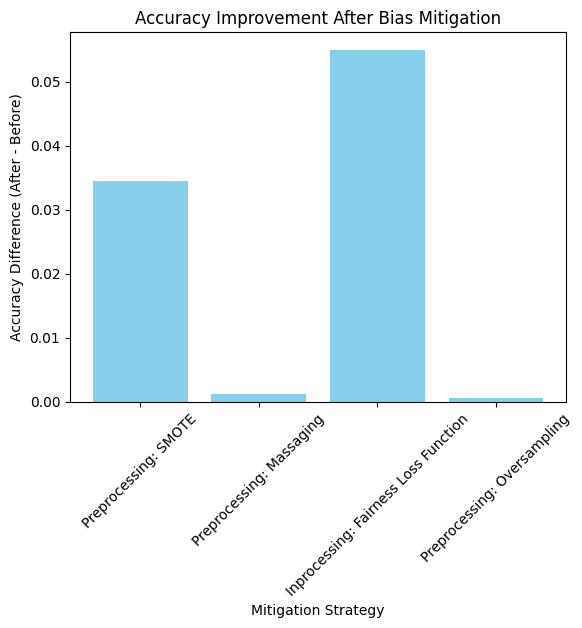

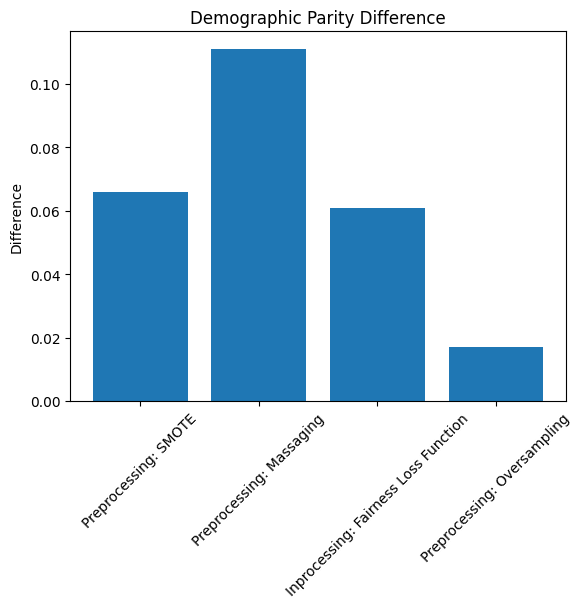

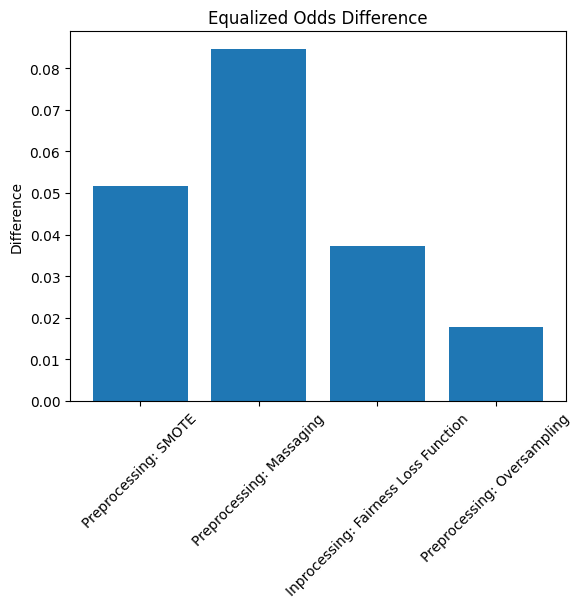

In [ ]:
#Accuracy Change
plt.figure()
plt.bar(df_merged["mitigation_strategy_after"], df_merged["accuracy_difference"], color='skyblue')
plt.xlabel("Mitigation Strategy")
plt.ylabel("Accuracy Difference (After - Before)")
plt.title("Accuracy Improvement After Bias Mitigation")
plt.xticks(rotation=45)
plt.show()

#plots demographic parity
plt.figure()
plt.bar(filtered_results["mitigation_strategy"], filtered_results["demographic_parity_difference"])
plt.title("Demographic Parity Difference")
plt.ylabel("Difference")
plt.xticks(rotation = 45)
plt.show()

#plots equalized odds
plt.figure()
plt.bar(filtered_results["mitigation_strategy"], filtered_results["equalized_odds_difference"])
plt.title("Equalized Odds Difference")
plt.ylabel("Difference")
plt.xticks(rotation = 45)
plt.show()

[Briefly describe overall findings and conclusions here. Which mitigation strategy resulted in most improvement? Which resulted in the least improvement? Visualize the results with some informative plots. (Hint: Use the `overall_results` table).]

The results from our analysis show that fairness loss was the most effective strategy with the highest accuracy improvement of 5.76% and a slight reduction in demographic parity and equalized odds, showing a balanced improvement. SMOTE with convergence showed similar improvements, with a 3.5% increase in accuracy and a decrease in fairness metrics by about half. Oversampling showed the poor improvements, with only a .05% increase in accuracy and minor fairness changes with an overall minimal impact. Equalized odds difference remained the lowest out of all the different measurements as well as demographic parity. Massaging showed the worst results where the massaging technique, it showed a .12% increase in accuracy; however, fairness metrics noteably worsened with demographic parity and equalized odds increasing, showing a introduced bias.

# References
- Teammate 1: N/A
- Teammate 2: https://www.holisticai.com/blog/bias-mitigation-strategies-techniques-for-classification-tasks
- Teammate 3: N/A
- Teammate 4: N/A

# Disclosures
- Teammate 1: Used generative AI to solve errors, explain code, improve through scaling, and conclusion graphing.
- Teammate 2: Used generative AI to aid in debugging, interpreting errors, and some guidance, however, all ideas and conclusions were my own.
- Teammate 3: Used generative AI to aid in determining how to create the idea of a loss score for the model.
- Teammate 4: Use generative aid in debugging and create an understanding of errors and models.